In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(sys.path[0]))))

In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'True'
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image,ImageDraw
import easyocr
import numpy as np
import json
import re
import torch
from tqdm import tqdm
from scripts.train.utils import smart_tokenizer_and_embedding_resize,Html2BboxTree,move_to_device,BboxTree2Html,add_special_tokens
from vars import *
from my_dataset import UICoderDataset,UICoderCollater
from transformers import AutoProcessor, Pix2StructForConditionalGeneration,AddedToken
from utils import Html2BboxTree, BboxTree2StyleList, BboxTree2Html
from datasets import Dataset


torch.manual_seed(SEED)

device = 'cuda:0'
# bbox_model_path = "/data02/users/lz/code/UICoder/checkpoints/stage1/l2048_p1024_vu_3m*1/checkpoint-200000"
bbox_model_path = "/data02/users/lz/code/UICoder/checkpoints/stage1/l2048_p1024_vu2048_3m*1/checkpoint-55000"
style_model_path = "/data02/users/lz/code/UICoder/checkpoints/stage2/l256_p512_ws_30k*3/checkpoint-40000"

data_path = '/data02/starmage/datasets/cc/arrows_8-14_processed/'
# data_path = '/data02/users/lz/code/UICoder/datasets/WebSight-format-parquet/arrow'
output_dir = '/data02/users/lz/code/UICoder/test_result'

/data02/users/lz/miniconda3/envs/UICoder/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
processor = AutoProcessor.from_pretrained(processor_name_or_path)
model_bbox = Pix2StructForConditionalGeneration.from_pretrained(bbox_model_path,is_encoder_decoder=True,device_map=device,torch_dtype=torch.float16)
model_style = Pix2StructForConditionalGeneration.from_pretrained(style_model_path,is_encoder_decoder=True,device_map=device,torch_dtype=torch.float16)
add_special_tokens(model_bbox,processor.tokenizer)
add_special_tokens(model_style,processor.tokenizer)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


In [4]:
# ds = UICoderDataset(path=data_path,processor=processor,max_length=1024,max_patches=1024,max_num=100,drop_longer=True,stage=1,preprocess=True, make_patches_while_training=True, workers=1)
ds = Dataset.load_from_disk(data_path)

In [32]:
idx = 102
image = ds[idx]['image']
# image

In [20]:
model_bbox.eval()
with torch.no_grad():
    input = f'<body bbox=['
    decoder_input_ids = processor.tokenizer.encode(input,return_tensors='pt',add_special_tokens=True)[...,:-1]
    encoding = processor(images=[image],text=[""],max_patches=1024,return_tensors='pt')
    item = {
        'decoder_input_ids': decoder_input_ids,
        'flattened_patches': encoding['flattened_patches'].half(),
        'attention_mask': encoding['attention_mask']
    }
    item = move_to_device(item,device)

    outputs = model_bbox.generate(**item,max_new_tokens=2560,eos_token_id=processor.tokenizer.eos_token_id,do_sample=True)
            
    prediction_html = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]


In [21]:
print(len(processor.tokenizer.encode(prediction_html)))
prediction_html

1444


'<body bbox=[0.0, 0.0, 1.0, 1.0]><div bbox=[0.0, 0.0, 1.0, 1.0]><div bbox=[0.0, 0.0, 1.0, 0.029]><div bbox=[0.043, 0.0, 0.914, 0.029]><div bbox=[0.043, 0.0, 0.155, 0.023]><div bbox=[0.043, 0.006, 0.155, 0.01]><span bbox=[0.043, 0.005, 0.133, 0.007]></span></div></div><div bbox=[0.311, 0.0, 0.647, 0.023]></div></div></div><div bbox=[0.0, 0.029, 1.0, 0.054]><div bbox=[0.043, 0.037, 0.914, 0.029]><div bbox=[0.043, 0.037, 0.914, 0.029]></div><span bbox=[0.921, 0.037, 0.036, 0.029]></span></div></div><div bbox=[0.043, 0.091, 0.914, 0.801]></div><div bbox=[0.0, 0.903, 1.0, 0.097]><div bbox=[0.043, 0.903, 0.914, 0.097]><div bbox=[0.031, 0.907, 0.938, 0.079]><div bbox=[0.031, 0.907, 0.312, 0.079]><div bbox=[0.043, 0.922, 0.289, 0.043]><div bbox=[0.043, 0.922, 0.289, 0.035]><div bbox=[0.043, 0.922, 0.289, 0.035]><a bbox=[0.043, 0.923, 0.289, 0.032]><img bbox=[0.043, 0.923, 0.289, 0.032]></img></a></div></div></div></div><div bbox=[0.344, 0.907, 0.312, 0.079]><div bbox=[0.355, 0.922, 0.289, 0.04

In [22]:
# print(len(processor.tokenizer.encode("<body bbox=[33,21,1000,455]>")))
# print(len(processor.tokenizer.encode("<body bbox=[33, 21, 1000, 455]>")))
# print(len(processor.tokenizer.encode("<body bbox=[0.33,0.22,0.01,0.45]>")))
# print(len(processor.tokenizer.encode("<body bbox=[0.33, 0.22, 0.01, 0.45]>")))
# print(len(processor.tokenizer.encode("<body bbox=[0.330,0.221,0.001,0.455]>")))
# print(len(processor.tokenizer.encode("<body bbox=[0.330, 0.221, 0.001, 0.455]>")))

In [23]:
processor.tokenizer.decode([1])

'</s>'

In [24]:
# aBbox = Html2BboxTree(answer_html)
pBbox = Html2BboxTree(prediction_html, size=image.size)
aImage = image.copy()
pImage = image.copy()

In [25]:

def drawBboxOnImage(draw: ImageDraw,bbox_node):
    bbox = bbox_node['bbox']
    if bbox[2] > 0 and bbox[3] > 0:
        draw.rectangle((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]),outline="red",width=2)
    for node in bbox_node['children']:
        drawBboxOnImage(draw, node)
        
def stickImages(images):
    sizes = list(map(lambda x: x.size,images))

    max_width = max(list(map(lambda x: x[0],sizes)))
    max_height = max(list(map(lambda x: x[1],sizes)))

    new_image = Image.new('RGB', ((max_width+10)*len(images), max_height))
    
    for idx,image in enumerate(images):
        new_image.paste(image, ((max_width+10)*idx, 0))

    return new_image

def remove_bbox(html_content):
    bbox_pattern = r' bbox=\[[^\]]*\]'
    cleaned_html = re.sub(bbox_pattern, '', html_content)
    return cleaned_html

In [33]:
ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1280x1050>,
 'bbox': '{"type": "body", "content": "", "style": "margin: 0 auto 0; padding: 0; font-family: Arial, Helvetica, sans-serif; font-size: 12px; color: #000; background-attachment: fixed; width: 960px", "bbox": [160, 16, 960, 1024], "children": [{"type": "div", "content": "", "style": "width: 920px; margin: 10px auto 10px; padding: 0 20px 15px 20px; border: double; background-attachment: fixed", "bbox": [160, 16, 966, 1024], "children": [{"type": "div", "content": "", "style": null, "bbox": [183, 34, 920, 101], "children": [{"type": "div", "content": "", "style": "width: 920px; margin: 15px 0 0 0; height: 100px; background-color: #333; border-bottom: #b3b3b3 1px solid", "bbox": [183, 34, 920, 101], "children": []}]}, {"type": "div", "content": "", "style": "background: #333; height: 32px; padding: 4px 0 0; margin-bottom: 10px", "bbox": [183, 135, 920, 36], "children": []}, {"type": "div", "content": "", "style": "

In [35]:
drawBboxOnImage(ImageDraw.Draw(aImage),json.loads(ds[idx]['bbox']))
drawBboxOnImage(ImageDraw.Draw(pImage),pBbox)

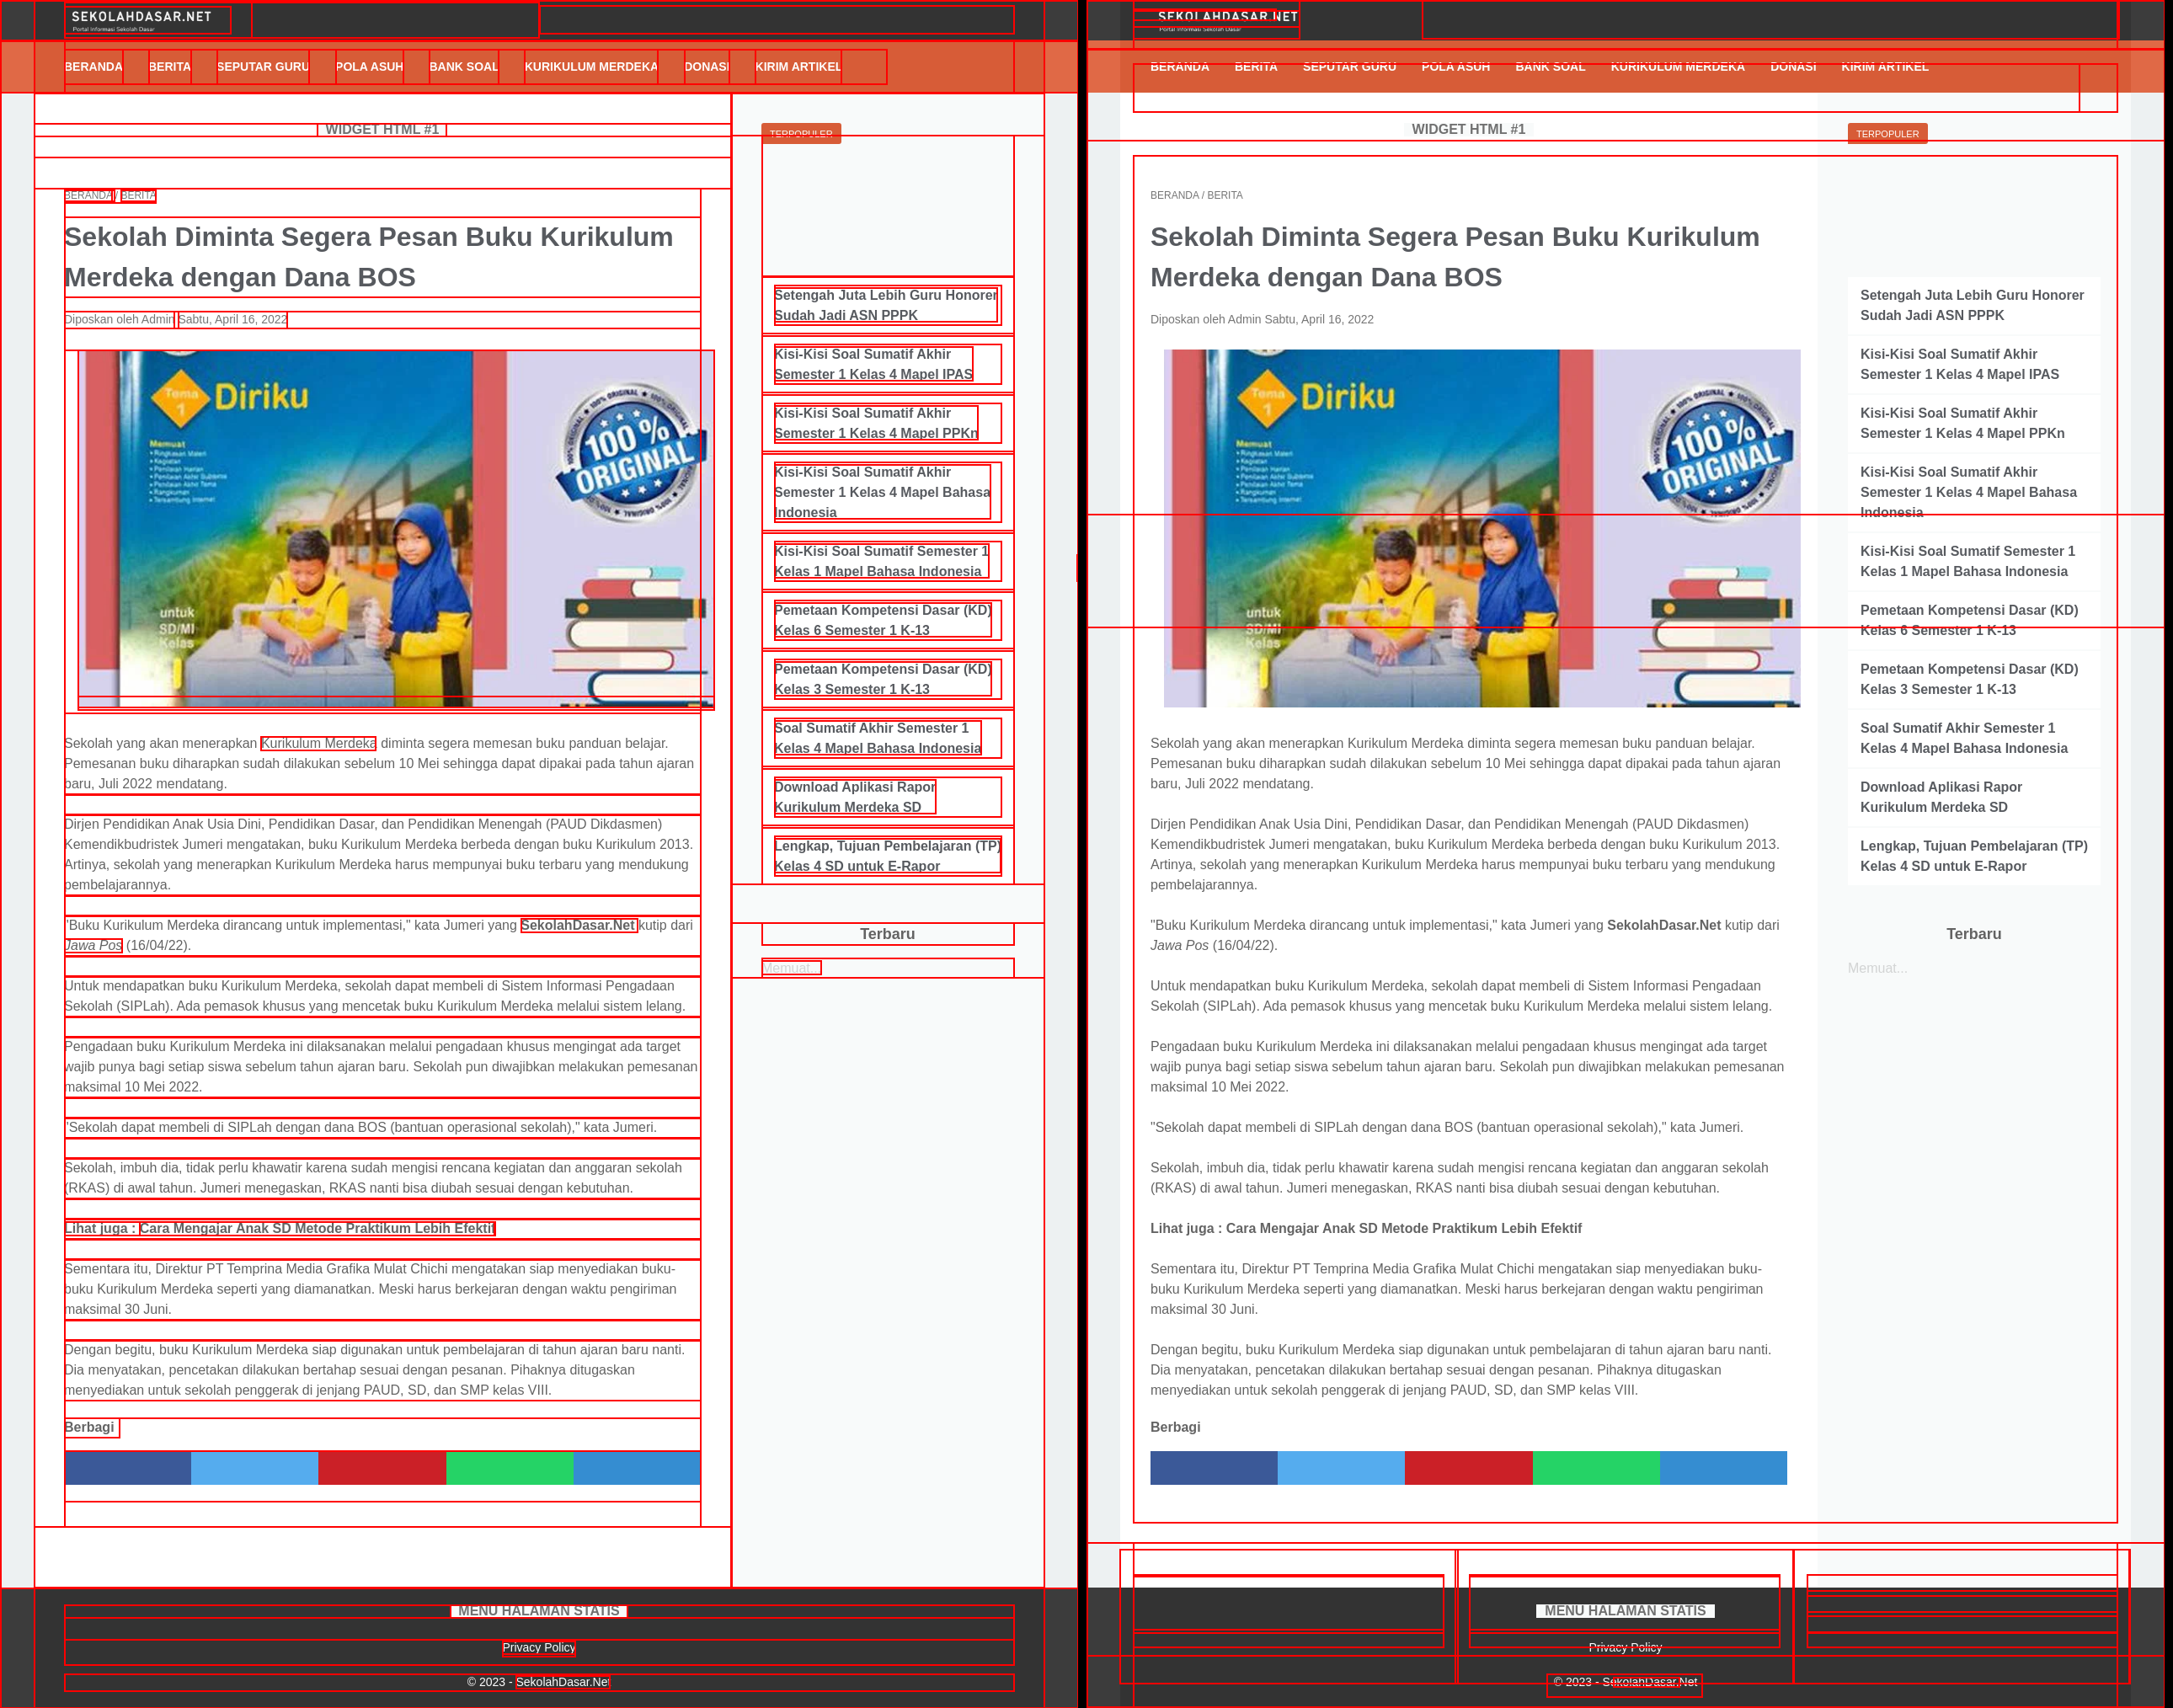

In [36]:
stickImages([aImage,pImage])

# For Style Test

In [28]:
def predictStyle(image,styleItem):
    cnode_type_bbox_list = list(map(lambda x: f'{x["type"]}({x["bbox"][0]-styleItem["bbox"][0]},{x["bbox"][1]-styleItem["bbox"][1]},{x["bbox"][2]},{x["bbox"]})', styleItem['children']))
    input = f"{styleItem['type']}<{','.join(cnode_type_bbox_list)}> %{styleItem['style']}%<%"
    decoder_input_ids = processor.tokenizer.encode(input,return_tensors='pt')[...,:-1]
    encoding = processor(images=[image],text=[""],max_patches=512,return_tensors='pt')
    item = {
        'decoder_input_ids': decoder_input_ids,
        'flattened_patches': encoding['flattened_patches'].half(),
        'attention_mask': encoding['attention_mask']
    }
    item = move_to_device(item,device)
    with torch.no_grad():
        outputs = model_style.generate(**item,max_new_tokens=256,eos_token_id=processor.tokenizer.eos_token_id)
        predictions = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)
    css = '<'.join(predictions[0].split('<')[2:]).strip()
    if css and css[0] == '%':
        css = css[1:]
    if css and css[-1] == '>':
        css = css[:-1]
    if css and css[-1] == '%':
        css = css[:-1]
    css = css.split('%,%')
    return css

In [29]:
bboxTree = Html2BboxTree(prediction_html, size=image.size)
indexList = BboxTree2StyleList(bboxTree, skip_leaf=False)

def locateByIndex(bboxTree,index):
    target = bboxTree
    for i in list(filter(lambda x: x,index.split('-'))):
        target = target['children'][int(i)]
    return target

for item in tqdm(indexList):
    bbox = item['bbox']
    index = item['index']

    if not item['children'] or bbox[2] <= bbox_padding*2 or bbox[3] <= bbox_padding*2:
        continue
    image_crop = image.crop((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]))
    predicted_css = predictStyle(image_crop,item)

    for idx, css_item in enumerate(predicted_css):
        index_tmp = f"{index}{'-' if index else ''}{idx}"
        target = locateByIndex(bboxTree, index_tmp)
        target['style'] = css_item

100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


# For Text and Image Apply

In [30]:
# reader = easyocr.Reader(['ch_sim','en'])

# img_idx = 0
# for item in tqdm(indexList):
#     if not len(item['children']):
#         bbox = item['bbox']
#         index = item['index']
#         if bbox[2] <= 0 or bbox[3] <= 0:
#             continue
#         image_crop = image.crop((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]))
#         image_crop_text = image.crop((bbox[0]-bbox_padding*5,bbox[1]-bbox_padding*5,bbox[0]+bbox[2]+bbox_padding*10,bbox[1]+bbox[3]+bbox_padding*10)).convert('L')
#         target = locateByIndex(bboxTree, index)
#         if item['type'] == 'img':
#             image_crop.save(os.path.join(output_dir,f'{img_idx}.png'))
#             target['children'] = [f'{img_idx}.png']
#             img_idx += 1
#         else:
#             result = reader.readtext(np.array(image_crop_text))
#             text = '\n'.join(list(map(lambda x: x[1], result)))
#             target['children'] = text

In [31]:
# predicted_html_with_style = BboxTree2Html(bboxTree,style=True)

# os.makedirs(output_dir, exist_ok=True)
# with open(os.path.join(output_dir,'index.html'),'w') as f:
#     f.write(predicted_html_with_style)